In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
import xesmf as xe

from keras.models import load_model

from mlprecip_plot import *

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
def make_cm(ds,mt,title=''):   

    ds=ds.sel(model=0,model_type=mt,)
    
    # Get Counts
    tp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==1))))
    tn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==0))))
    fp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==1))))
    fn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==0))))
    
    array=[[fp,tn],
           [tp,fn]]
    
    print('TP: ',tp,' FP: ',fp,' TN: ',tn,' FN: ',fn)
    df = pd.DataFrame(array, ['Negative','Positive'], ['Positive','Negative'])

    f, ax = pplt.subplots(ncols=1,nrows=1)

    ax.heatmap(df,labels=True,cmap='viridis') 
    ax.format(ylabel='True',xlabel='Predicted')
    f.format(suptitle=title)

    return

In [3]:
#model_data_fname='../data/cnn/model_output.JJA.nc'
model_data_fname='/scratch/kpegion/model_output.JJA.nc'
#model_data_fname='/scratch/kpegion/model_output.DJF.nc'
varname='precip'
#varname='z500'


# Data

In [4]:
ds_model=xr.open_dataset(model_data_fname,chunks='auto')
ds_model

<xarray.Dataset>
Dimensions:     (rules: 2, time: 3588, lat: 37, lon: 72, var: 6, model_type: 1, model: 2, cat: 2)
Coordinates:
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * time        (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2017-08-31
  * lat         (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * lon         (lon) int64 0 5 10 15 20 25 30 ... 325 330 335 340 345 350 355
  * var         (var) object 'z500' 'z850' 'u200' 'u850' 'olr' 'sst'
  * model       (model) int64 0 1
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) int64 dask.array<chunksize=(3588,), meta=np.ndarray>
  * model_type  (model_type) object 'cnn_cat'
Data variables:
    lrp         (model_type, model, rules, time, lat, lon, var) float32 dask.array<chunksize=(1, 1, 1, 1794, 37, 36, 3), meta=np.ndarray>
    pred        (model_type, model, time) int64 dask.array<chunksize=(1, 2, 3588), meta=np.ndarray>
    verif       (model_type, model, time) int64 dask.array<chunksize=(1, 2, 3588), meta=np.ndarray>
    probs       (model_type, model, time, cat) float32 dask.array<chunksize=(1, 2, 3588, 2), meta=np.ndarray>
    acc         (model_type, model) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    val_acc     (model_type, model) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip      (model_type, time) float32 dask.array<chunksize=(1, 3588), meta=np.ndarray>

In [5]:
ds_model['lrp']=ds_model['lrp']/ds_model['lrp'].std(['lat','lon'],skipna=True)

#ds=ds_model['lrp'].sel(model_type='cnn_cat',rules='lrp.alpha_1_beta_0')
ds_mean=ds_model['lrp'].mean(dim=['time','model'],skipna=True)
ds_max=ds_model['lrp'].max(dim=['lat','lon','var'],skipna=True)
ds_model['lrp']=xr.where(np.abs(ds_max)>1e-8,ds_model['lrp']/ds_max,np.nan)
ds_model

In [6]:
# train=0,test=1
train_test=np.zeros((len(ds_model['time'])))
train_test[2870::]=1
da_tt=xr.DataArray(train_test,coords={'time':ds_model['time']},dims=['time']).to_dataset(name='tt')
ds_model=xr.merge([da_tt,ds_model],compat='override')

In [7]:
ds_model

<xarray.Dataset>
Dimensions:     (time: 3588, rules: 2, lat: 37, lon: 72, var: 6, model_type: 1, model: 2, cat: 2)
Coordinates:
  * time        (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2017-08-31
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * lat         (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * lon         (lon) int64 0 5 10 15 20 25 30 ... 325 330 335 340 345 350 355
  * var         (var) object 'z500' 'z850' 'u200' 'u850' 'olr' 'sst'
  * model       (model) int64 0 1
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) int64 dask.array<chunksize=(3588,), meta=np.ndarray>
  * model_type  (model_type) object 'cnn_cat'
Data variables:
    tt          (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    lrp         (model_type, model, rules, time, lat, lon, var) float32 dask.array<chunksize=(1, 1, 1, 1794, 37, 36, 3), meta=np.ndarray>
    pred        (model_type, model, time) int64 dask.array<chunksize=(1, 2, 3588), meta=np.ndarray>
    verif       (model_type, model, time) int64 dask.array<chunksize=(1, 2, 3588), meta=np.ndarray>
    probs       (model_type, model, time, cat) float32 dask.array<chunksize=(1, 2, 3588, 2), meta=np.ndarray>
    acc         (model_type, model) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    val_acc     (model_type, model) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip      (model_type, time) float32 dask.array<chunksize=(1, 3588), meta=np.ndarray>

# Forecasts

cnn_cat CNN
<xarray.Dataset>
Dimensions:     (time: 3588, lat: 37, lon: 72, var: 6, model: 2, cat: 2)
Coordinates:
  * time        (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2017-08-31
    rules       <U18 'lrp.alpha_1_beta_0'
  * lat         (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * lon         (lon) int64 0 5 10 15 20 25 30 ... 325 330 335 340 345 350 355
  * var         (var) object 'z500' 'z850' 'u200' 'u850' 'olr' 'sst'
  * model       (model) int64 0 1
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) int64 dask.array<chunksize=(3588,), meta=np.ndarray>
    model_type  <U7 'cnn_cat'
Data variables:
    tt          (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    lrp         (model, time, lat, lon, var) float32 dask.array<chunksize=(1, 1794, 37, 36, 3), meta=np.ndarray>
    pred        (model, time) int64 dask.array<chunksize=(2, 3588), meta=np.ndarray>
    verif       (model, time) int64 dask.array<chunksize=(2, 

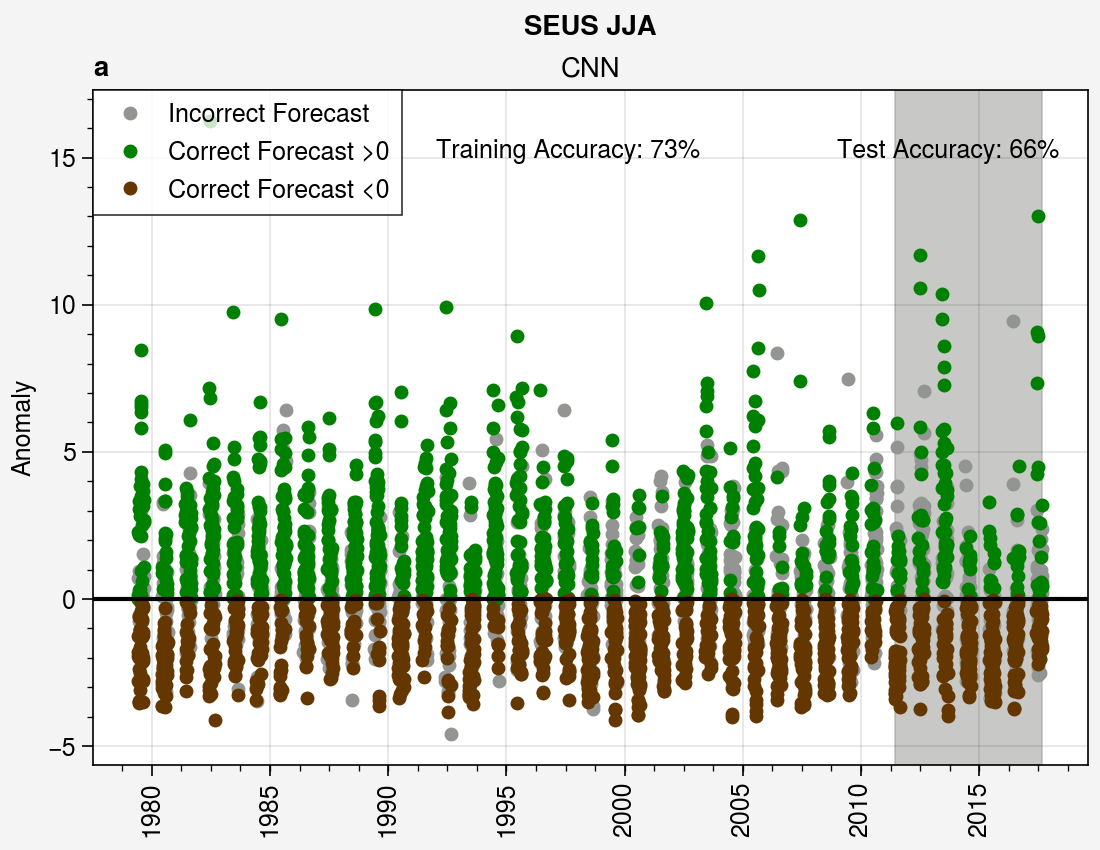

In [8]:
f,axs=pplt.subplots(ncols=1,nrows=len(ds_model['model_type'].values),figsize=(5.5,4.25))


for (ax,mtype,l) in zip(axs,ds_model['model_type'].values,['CNN']):
    print(mtype,l)
    hs=[]
    
    # Select the model type
    ds=ds_model.sel(model_type=mtype,rules='lrp.alpha_1_beta_0')
    print(ds)
    da=ds[varname]
    da_pred=ds['pred'].sel(model=0)
    da_verif=ds['verif'].sel(model=0)
    thresh=np.percentile(da,50)
    
    # Plot gray where fcsts are not correct
    tmp=da.where(da_pred!=da_verif)
    h=ax.plot(tmp['time'].values,tmp.values,color='gray',marker='.',markersize=8,linestyle='None')
    hs.append(h)
    
    # Plot correct positive forecasts in green
    tmp=da.where(np.logical_and(da_pred==da_verif,da>=thresh))
    h=ax.plot(tmp['time'].values,tmp.values,'g.',markersize=8,linestyle='None')
    hs.append(h)
    
    # Plot correct negative forecasts in brown
    tmp=da.where(np.logical_and(da_pred==da_verif,da<thresh))
    h=ax.plot(tmp['time'].values,tmp.values,color='brown',marker='.',markersize=8,linestyle='None')
    hs.append(h)

    # Draw median line
    ax.axhline(thresh,color='k')
    
    # Highlight test data
    ax.axvspan(ds_model['time'][2944].values, ds_model['time'][-1].values, color='gray', alpha=0.5)
    
    # Format subplot panel
    ax.format(title=l,abc=True)
    
    # Add custom legend
    ax.legend(hs, labels=['Incorrect Forecast', 'Correct Forecast >0','Correct Forecast <0'],ncols=1, loc='ul') 
    
    # Add text indicating accuracy of this model for test and train
    train_str='Training Accuracy: '+str(int(ds['acc'].sel(model=0)*100))+'%'
    test_str='Test Accuracy: '+str(int(ds['val_acc'].sel(model=0)*100))+'%'
    ax.text(pd.to_datetime('1992-01-01'),15,train_str,transform='data')
    ax.text(pd.to_datetime('2009-01-01'),15,test_str,transform='data')

# Figure labels
f.format(xlabel='', ylabel='Anomaly',suptitle='SEUS JJA')

del ds, da_pred, da_verif, da


# Accuracy

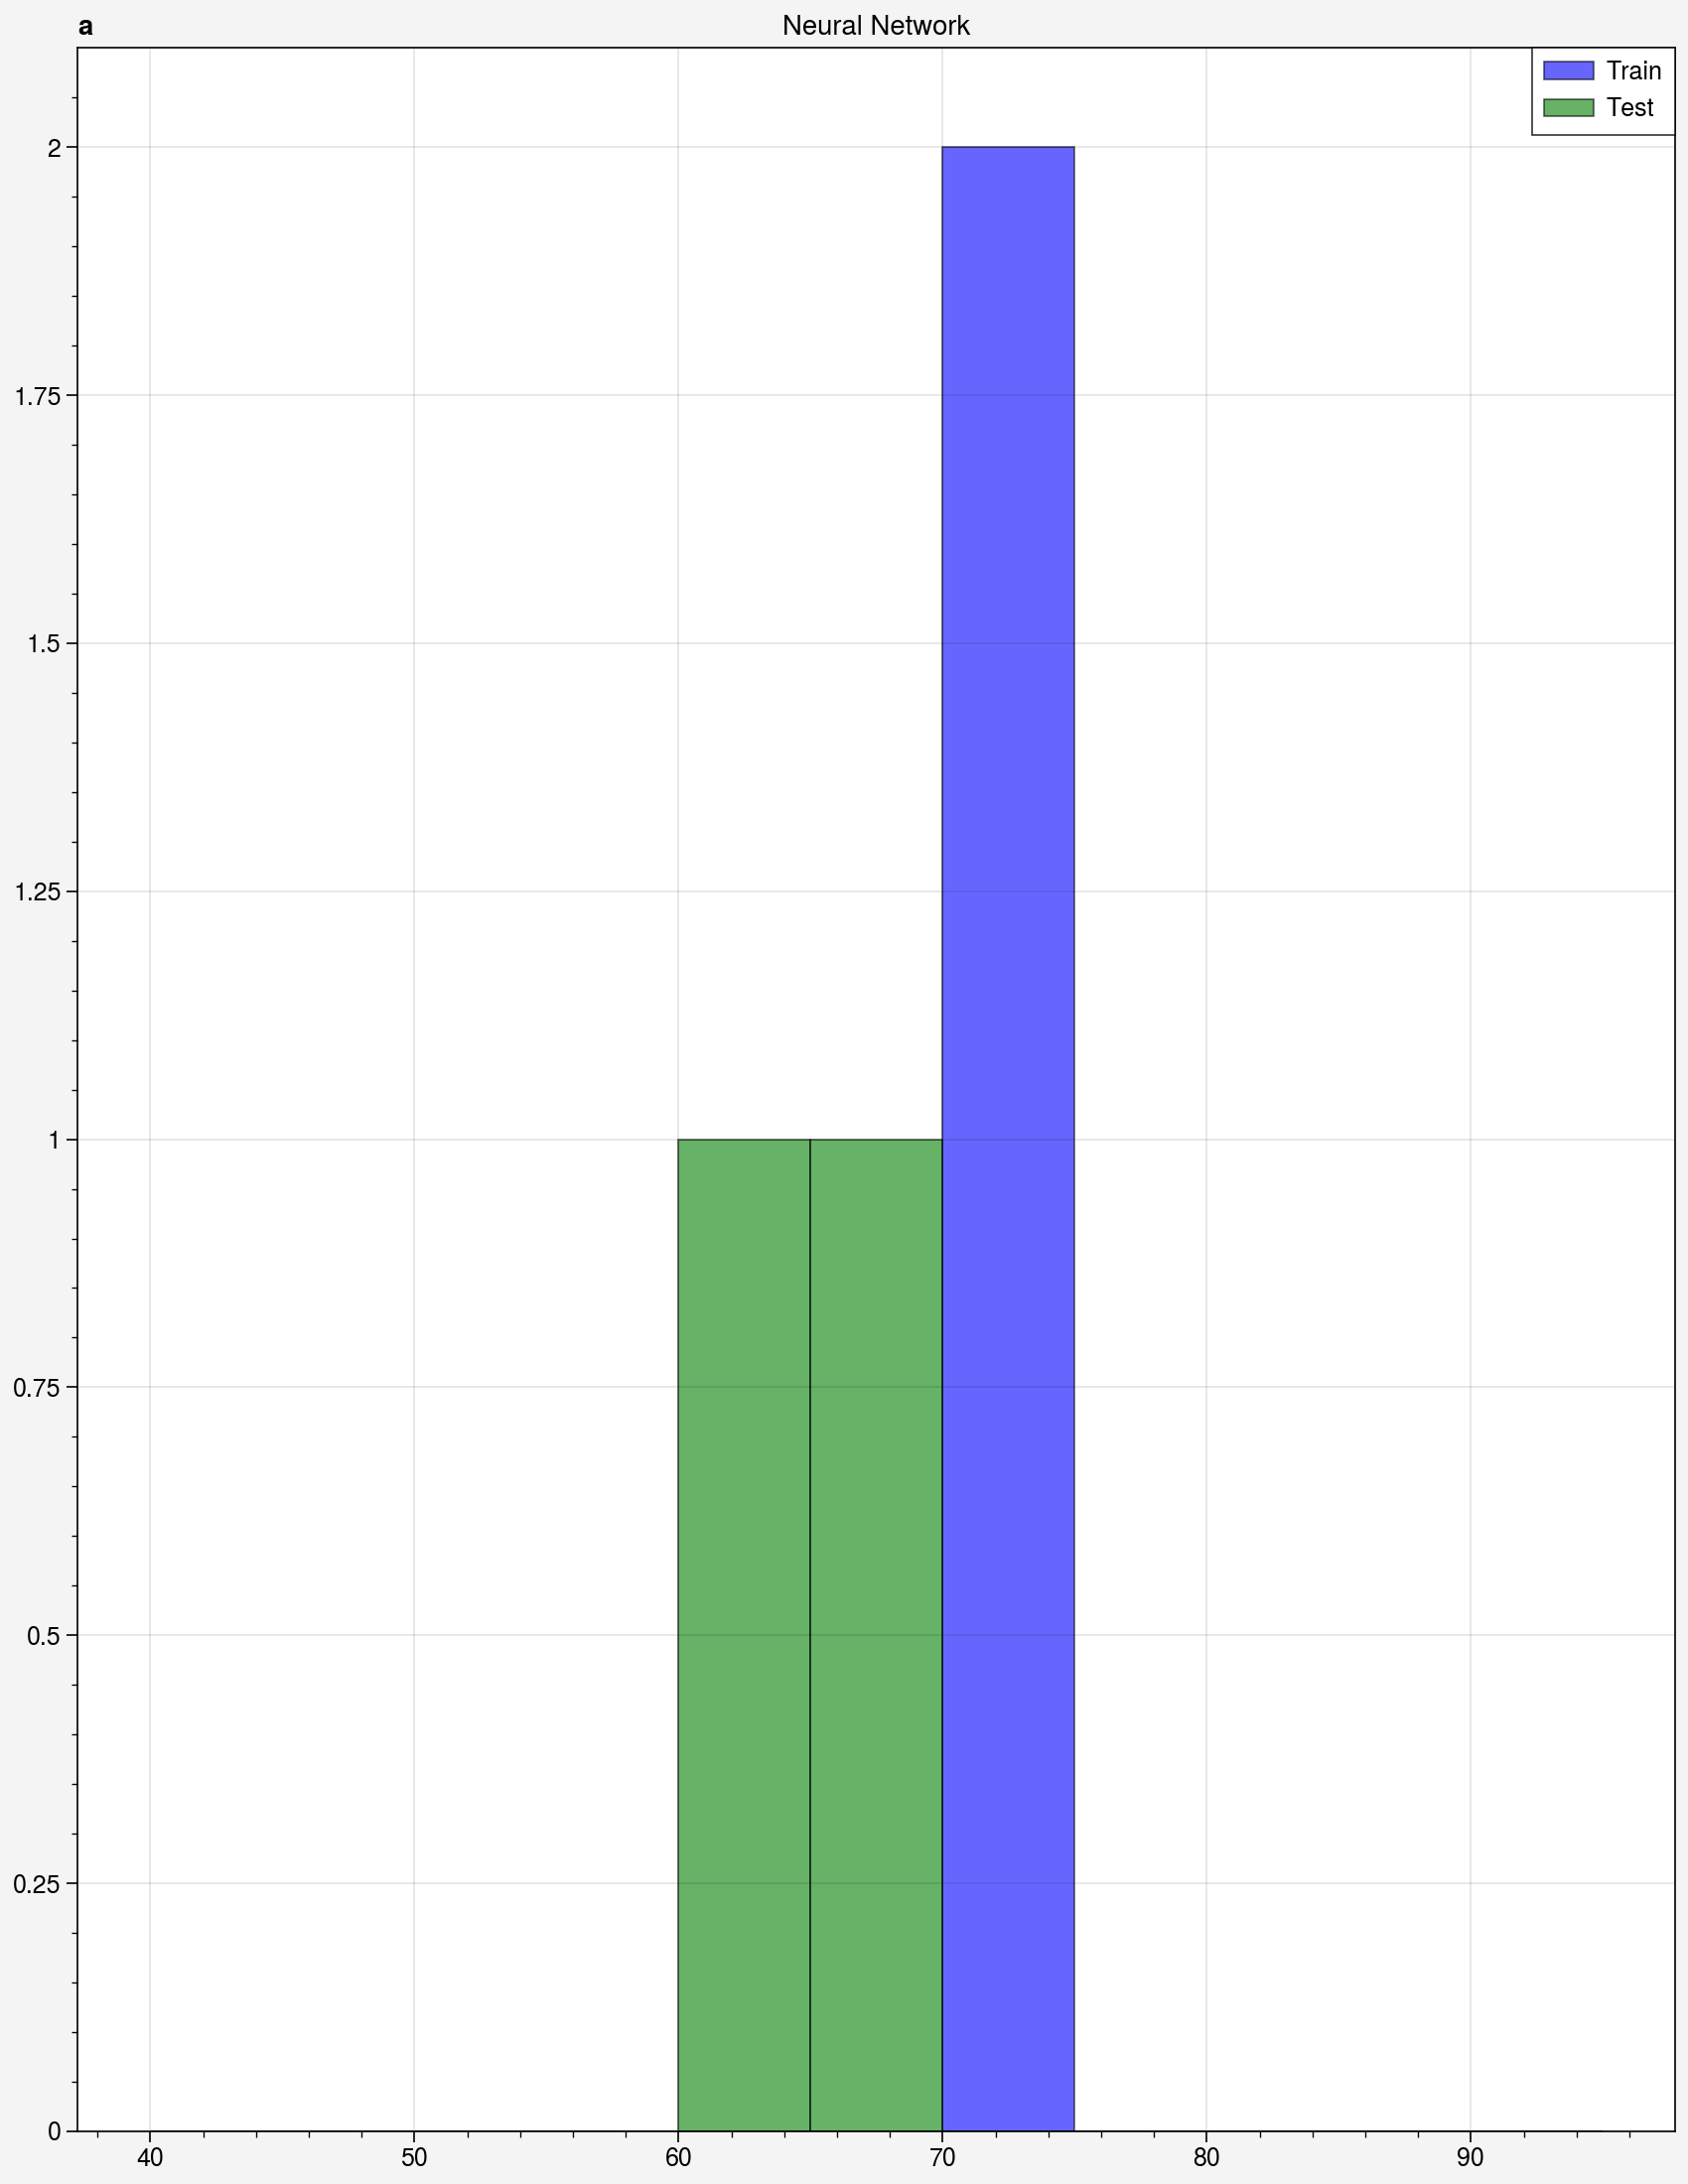

In [9]:
hist_bins=np.arange(40,100,5)
f,axs=pplt.subplots(ncols=1,nrows=len(ds_model['model_type'].values),figsize=(8.5,11))

for ax,mtype,l in zip(axs,ds_model['model_type'].values,['Neural Network']):

    hs=[]
    
    # Select the model type
    ds=ds_model.sel(model_type=mtype)
       
    h=ax.hist(ds['acc'].values*100,hist_bins,edgecolor='k',color='b',alpha=0.6)
    hs.append(h)
    
    h=ax.hist(ds['val_acc'].values*100,hist_bins,edgecolor='k',color='g',alpha=0.6)
    hs.append(h)
    
    # Format subplot panel
    ax.format(title=l,abc=True)

# Add custom legend
axs[0,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur') 

del ds

# Contingency Table

TP:  1200  FP:  399  TN:  1395  FN:  594


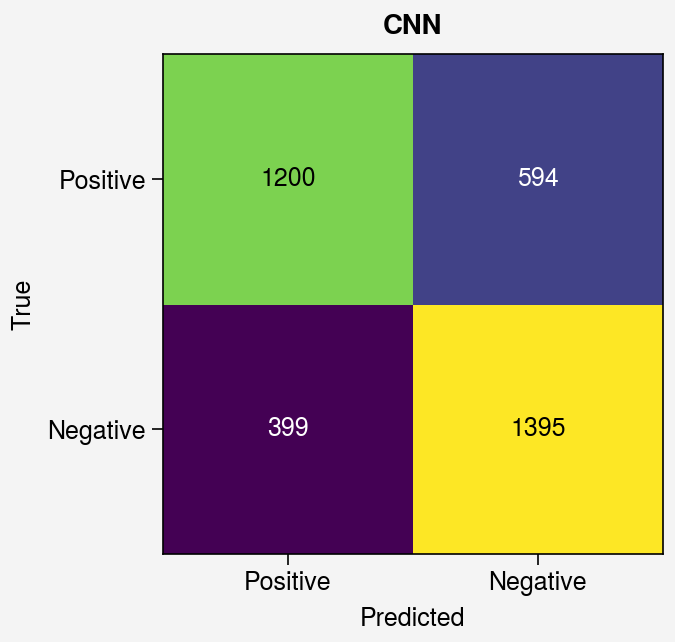

In [10]:
for i,t in zip(ds_model['model_type'].values,['CNN']):
    make_cm(ds_model,i,title=t)

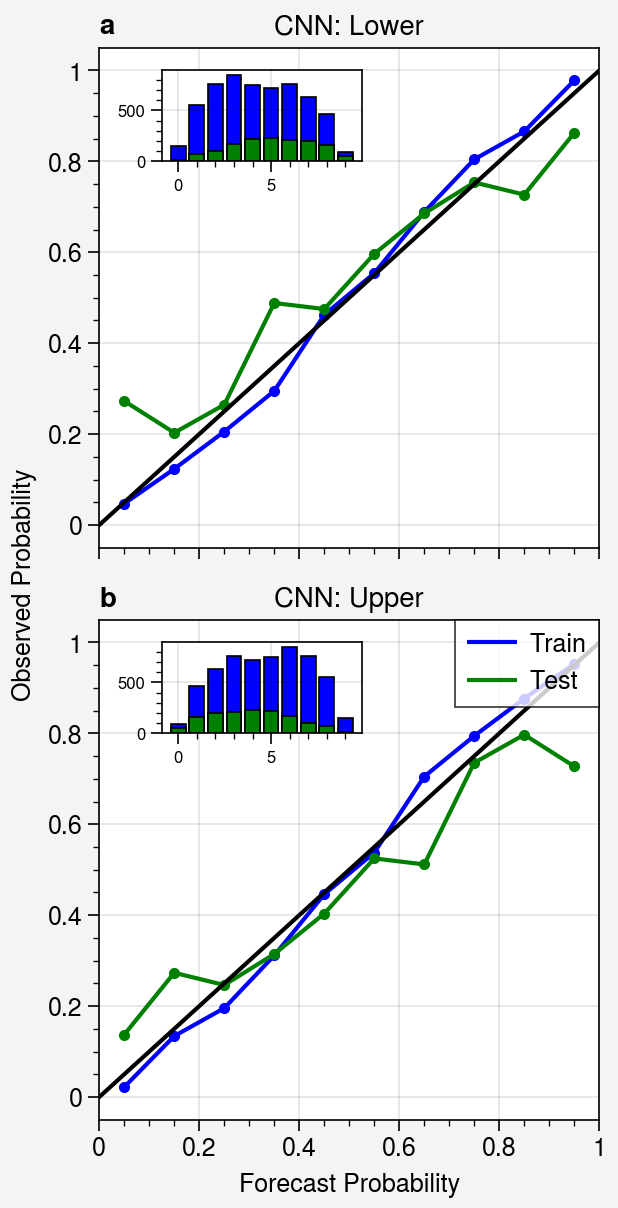

In [11]:
f, axs = pplt.subplots(ncols=len(ds_model['model_type'].values),nrows=len(ds_model['cat'].values))

rel_bins=np.arange(0,1.1,0.1)
   

for j,(mtype,l) in enumerate(zip(ds_model['model_type'].values,['CNN'])): 
    
    # Select the model
    ds=ds_model.sel(model_type=mtype)
    ds_train=xr.where(ds['tt']==0,ds,np.nan)
    ds_test=xr.where(ds['tt']==1,ds,np.nan)
    
    
    for i,cat in enumerate(ds['cat'].values):
        
        hs=[]
        
        # Calculate reliability
        rel_train=xs.reliability(ds_train['verif']==i,ds_train['probs'].sel(cat=cat),dim=['model','time'],
                                 probability_bin_edges=rel_bins)
        rel_test=xs.reliability(ds_test['verif']==i,ds_test['probs'].sel(cat=cat),dim=['model','time'],
                                 probability_bin_edges=rel_bins)
        
        # Plot reliability
        
        h=axs[i,j].plot(rel_train['forecast_probability'].values,rel_train.values,'b')
        axs[i,j].plot(rel_train['forecast_probability'].values,rel_train.values,'b.')
        hs.append(h)
        
        h=axs[i,j].plot(rel_test['forecast_probability'].values,rel_test.values,'g')
        axs[i,j].plot(rel_test['forecast_probability'].values,rel_test.values,'g.')
        hs.append(h)
        
        axs[i,j].format(xtickminor=True,ytickminor=True,title=l+': '+cat,
                        xlabel='Forecast Probability',ylabel='Observed Probability',
                        abc=True)
        
        # Perfect reliability line
        axs[i,j].plot(rel_bins,rel_bins,'k')
        
        # Histogram inset
        axi = axs[i,j].inset([0.125, 0.8, 0.4, 0.2], transform='data',zoom=False)
        axi.bar(rel_train['samples'].values,color='b')
        axi.bar(rel_test['samples'].values,color='g')

        axi.format(xtickminor=True,ytickminor=True,fontsize=6)
        
    # Add custom legend
    axs[1,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur')
    
    del ds, ds_train, ds_test, rel_train, rel_test


In [12]:
tfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
zfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.*.nc'
ufiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.*.nc'

# Z500 and Z850
ds_z=xr.open_mfdataset(zfiles,combine='by_coords')
ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

# U200 and U850
ds_u=xr.open_mfdataset(ufiles,combine='by_coords')
ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
ds_u850=ds_u.sel(level=850).rename({'u':'u850'})

# SST
ds_sst=xr.open_mfdataset(tfiles,combine='by_coords')

# OLR
olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'
ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts')
ds_olr1['time']=ds_olr1['time'].dt.floor('d')
ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords')
ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})
ds_olr['olr']=ds_olr['olr']*-1



In [13]:
# Coarse Grain Data
new_lon=np.arange(0,360,5)
new_lat=np.arange(-90,92,5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)})

regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
ds_z500=regridder(ds_z500)
ds_z850=regridder(ds_z850)
ds_olr=regridder(ds_olr)
ds_u200=regridder(ds_u200)
ds_u850=regridder(ds_u850)

regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
ds_sst=regridder_sst(ds_sst)

In [14]:
ds=xr.merge([ds_sst,ds_z500,ds_z850,ds_olr,ds_u200,ds_u850],compat='override')
ds_anoms=ds.groupby('time.dayofyear')-ds.groupby('time.dayofyear').mean()


/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


# Contribution of Predictors

### Mean Relevance

z500 GeoAxesSubplot(nrows=3, ncols=2, index=(0, 0), number=1, backend='cartopy')
z850 GeoAxesSubplot(nrows=3, ncols=2, index=(1, 1), number=2, backend='cartopy')
u200 GeoAxesSubplot(nrows=3, ncols=2, index=(2, 2), number=3, backend='cartopy')
u850 GeoAxesSubplot(nrows=3, ncols=2, index=(3, 3), number=4, backend='cartopy')
olr GeoAxesSubplot(nrows=3, ncols=2, index=(4, 4), number=5, backend='cartopy')
sst GeoAxesSubplot(nrows=3, ncols=2, index=(5, 5), number=6, backend='cartopy')


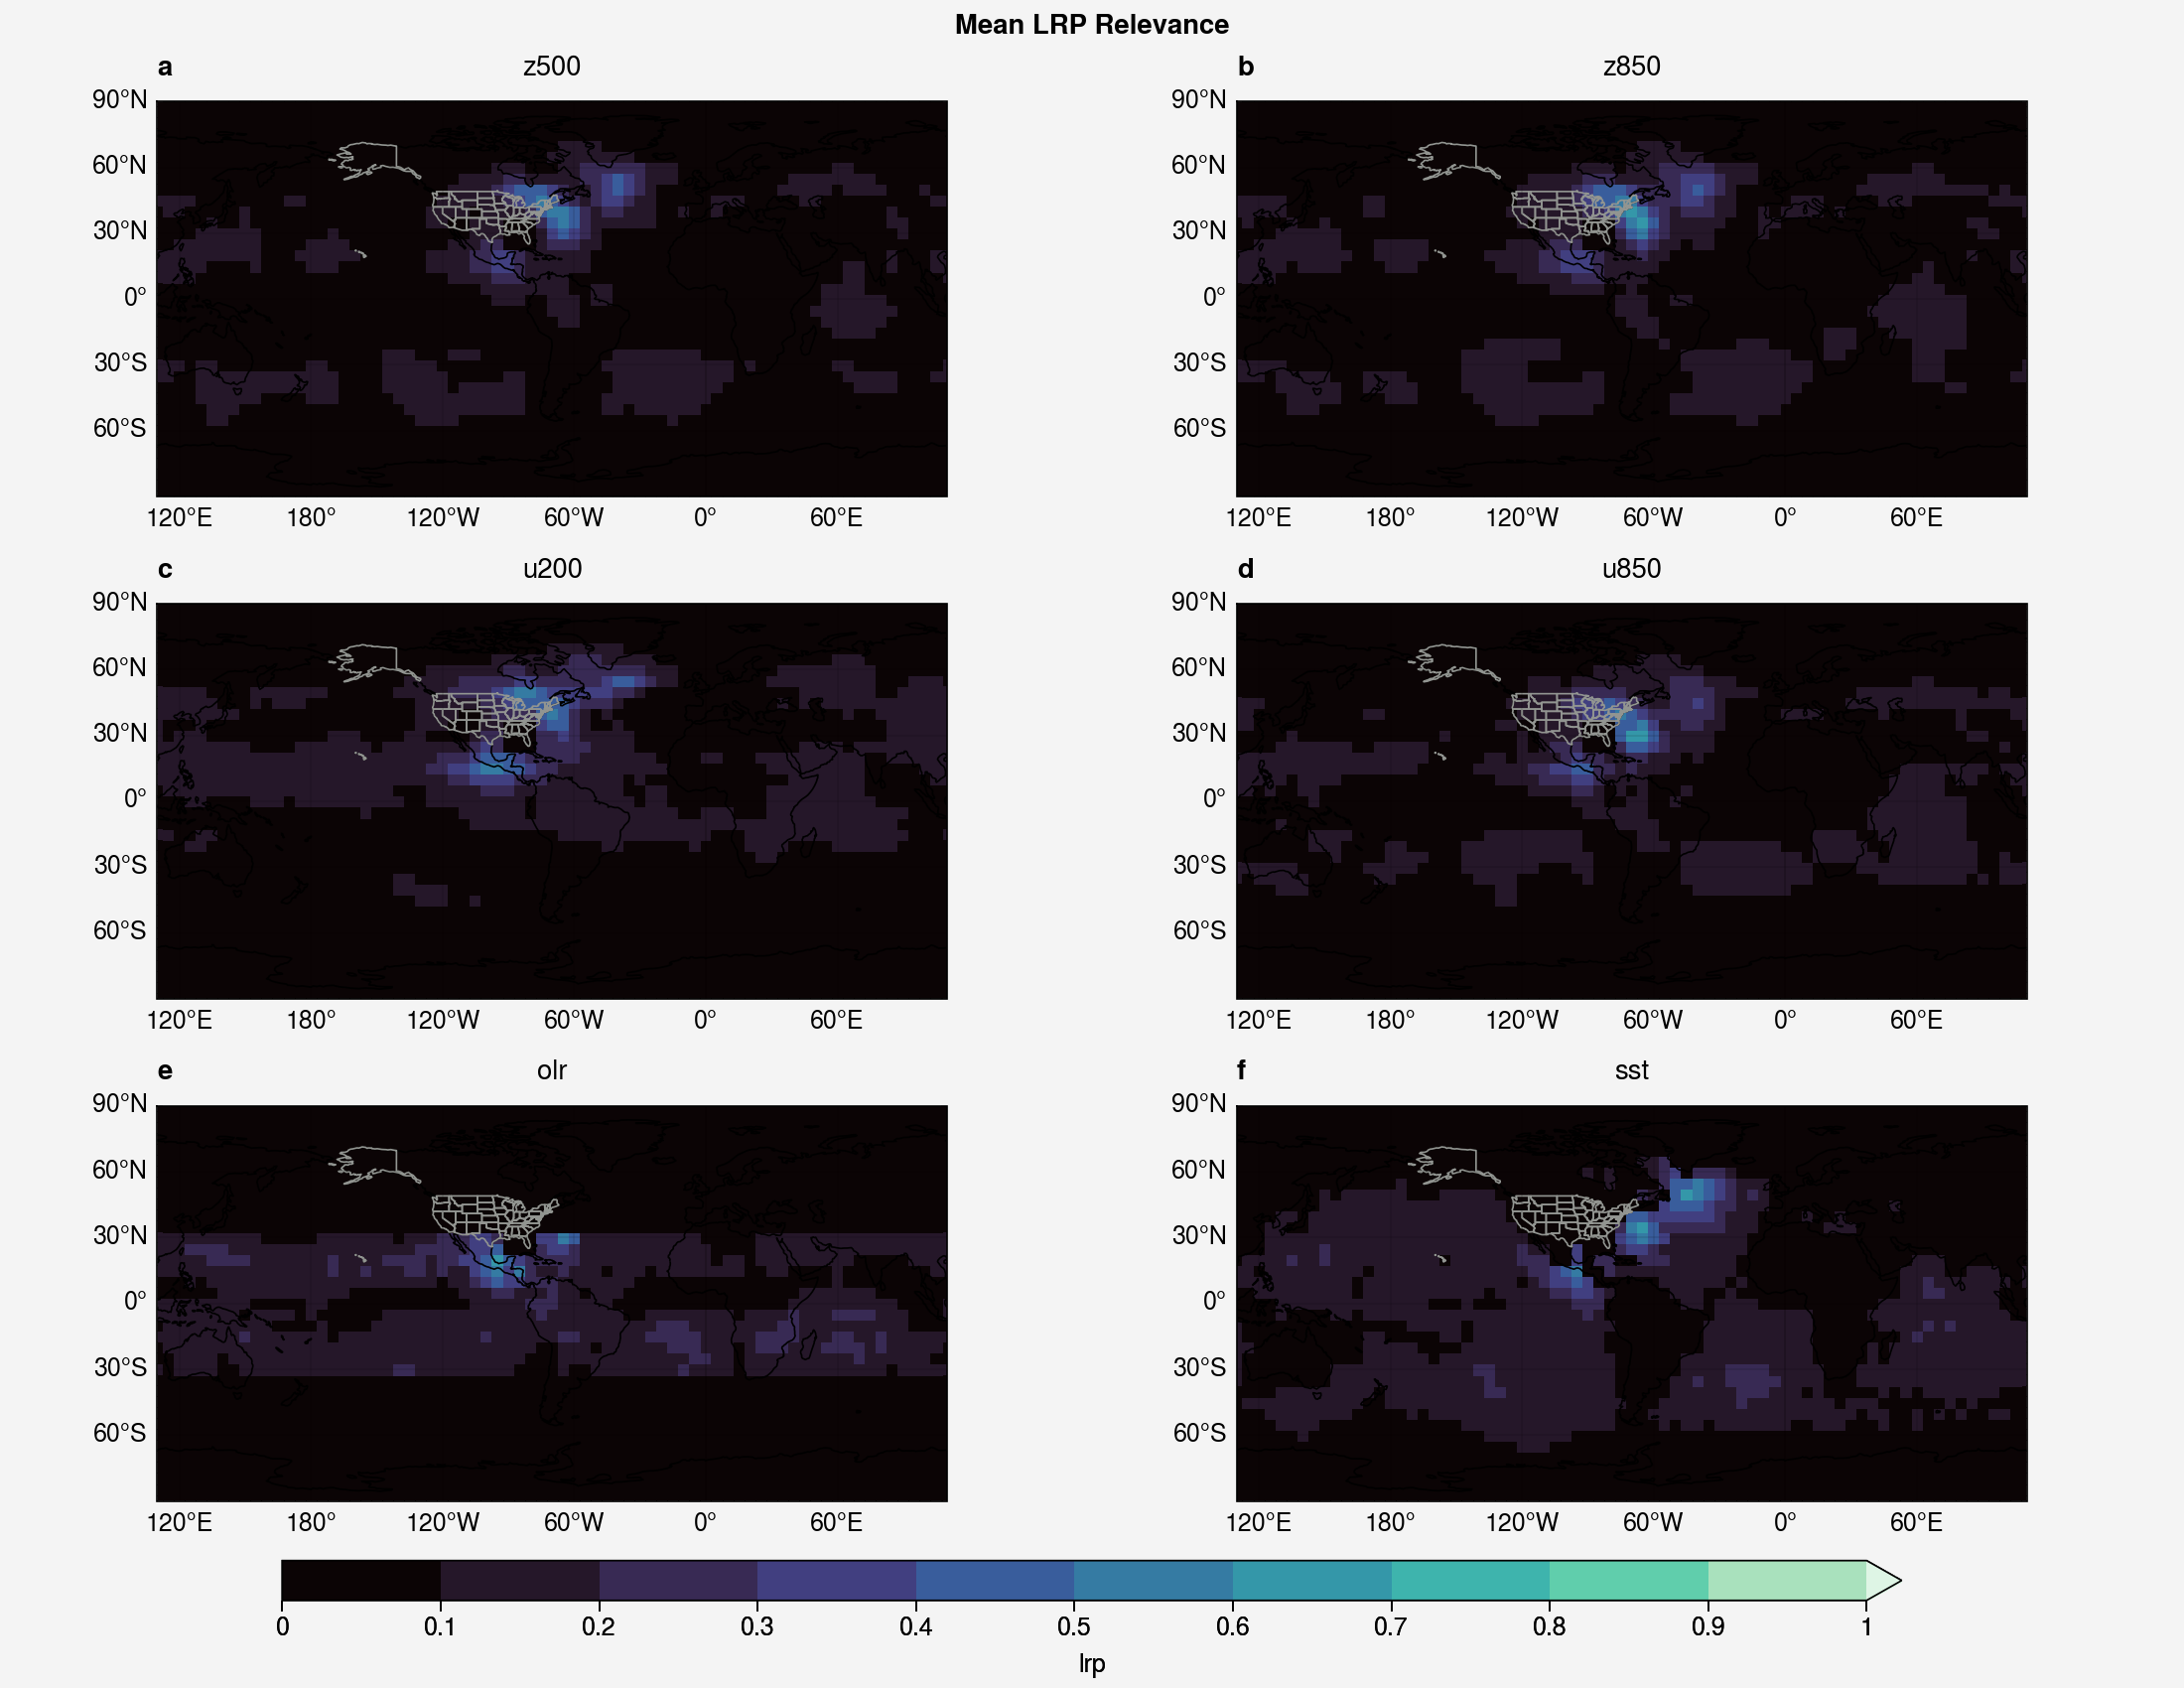

In [15]:
plotLRP_map(ds_model,['time','model'],'lrp.alpha_1_beta_0',cm='mako')


### True Negative Relevance

657
z500 GeoAxesSubplot(nrows=3, ncols=2, index=(0, 0), number=1, backend='cartopy')
z850 GeoAxesSubplot(nrows=3, ncols=2, index=(1, 1), number=2, backend='cartopy')
u200 GeoAxesSubplot(nrows=3, ncols=2, index=(2, 2), number=3, backend='cartopy')
u850 GeoAxesSubplot(nrows=3, ncols=2, index=(3, 3), number=4, backend='cartopy')
olr GeoAxesSubplot(nrows=3, ncols=2, index=(4, 4), number=5, backend='cartopy')
sst GeoAxesSubplot(nrows=3, ncols=2, index=(5, 5), number=6, backend='cartopy')


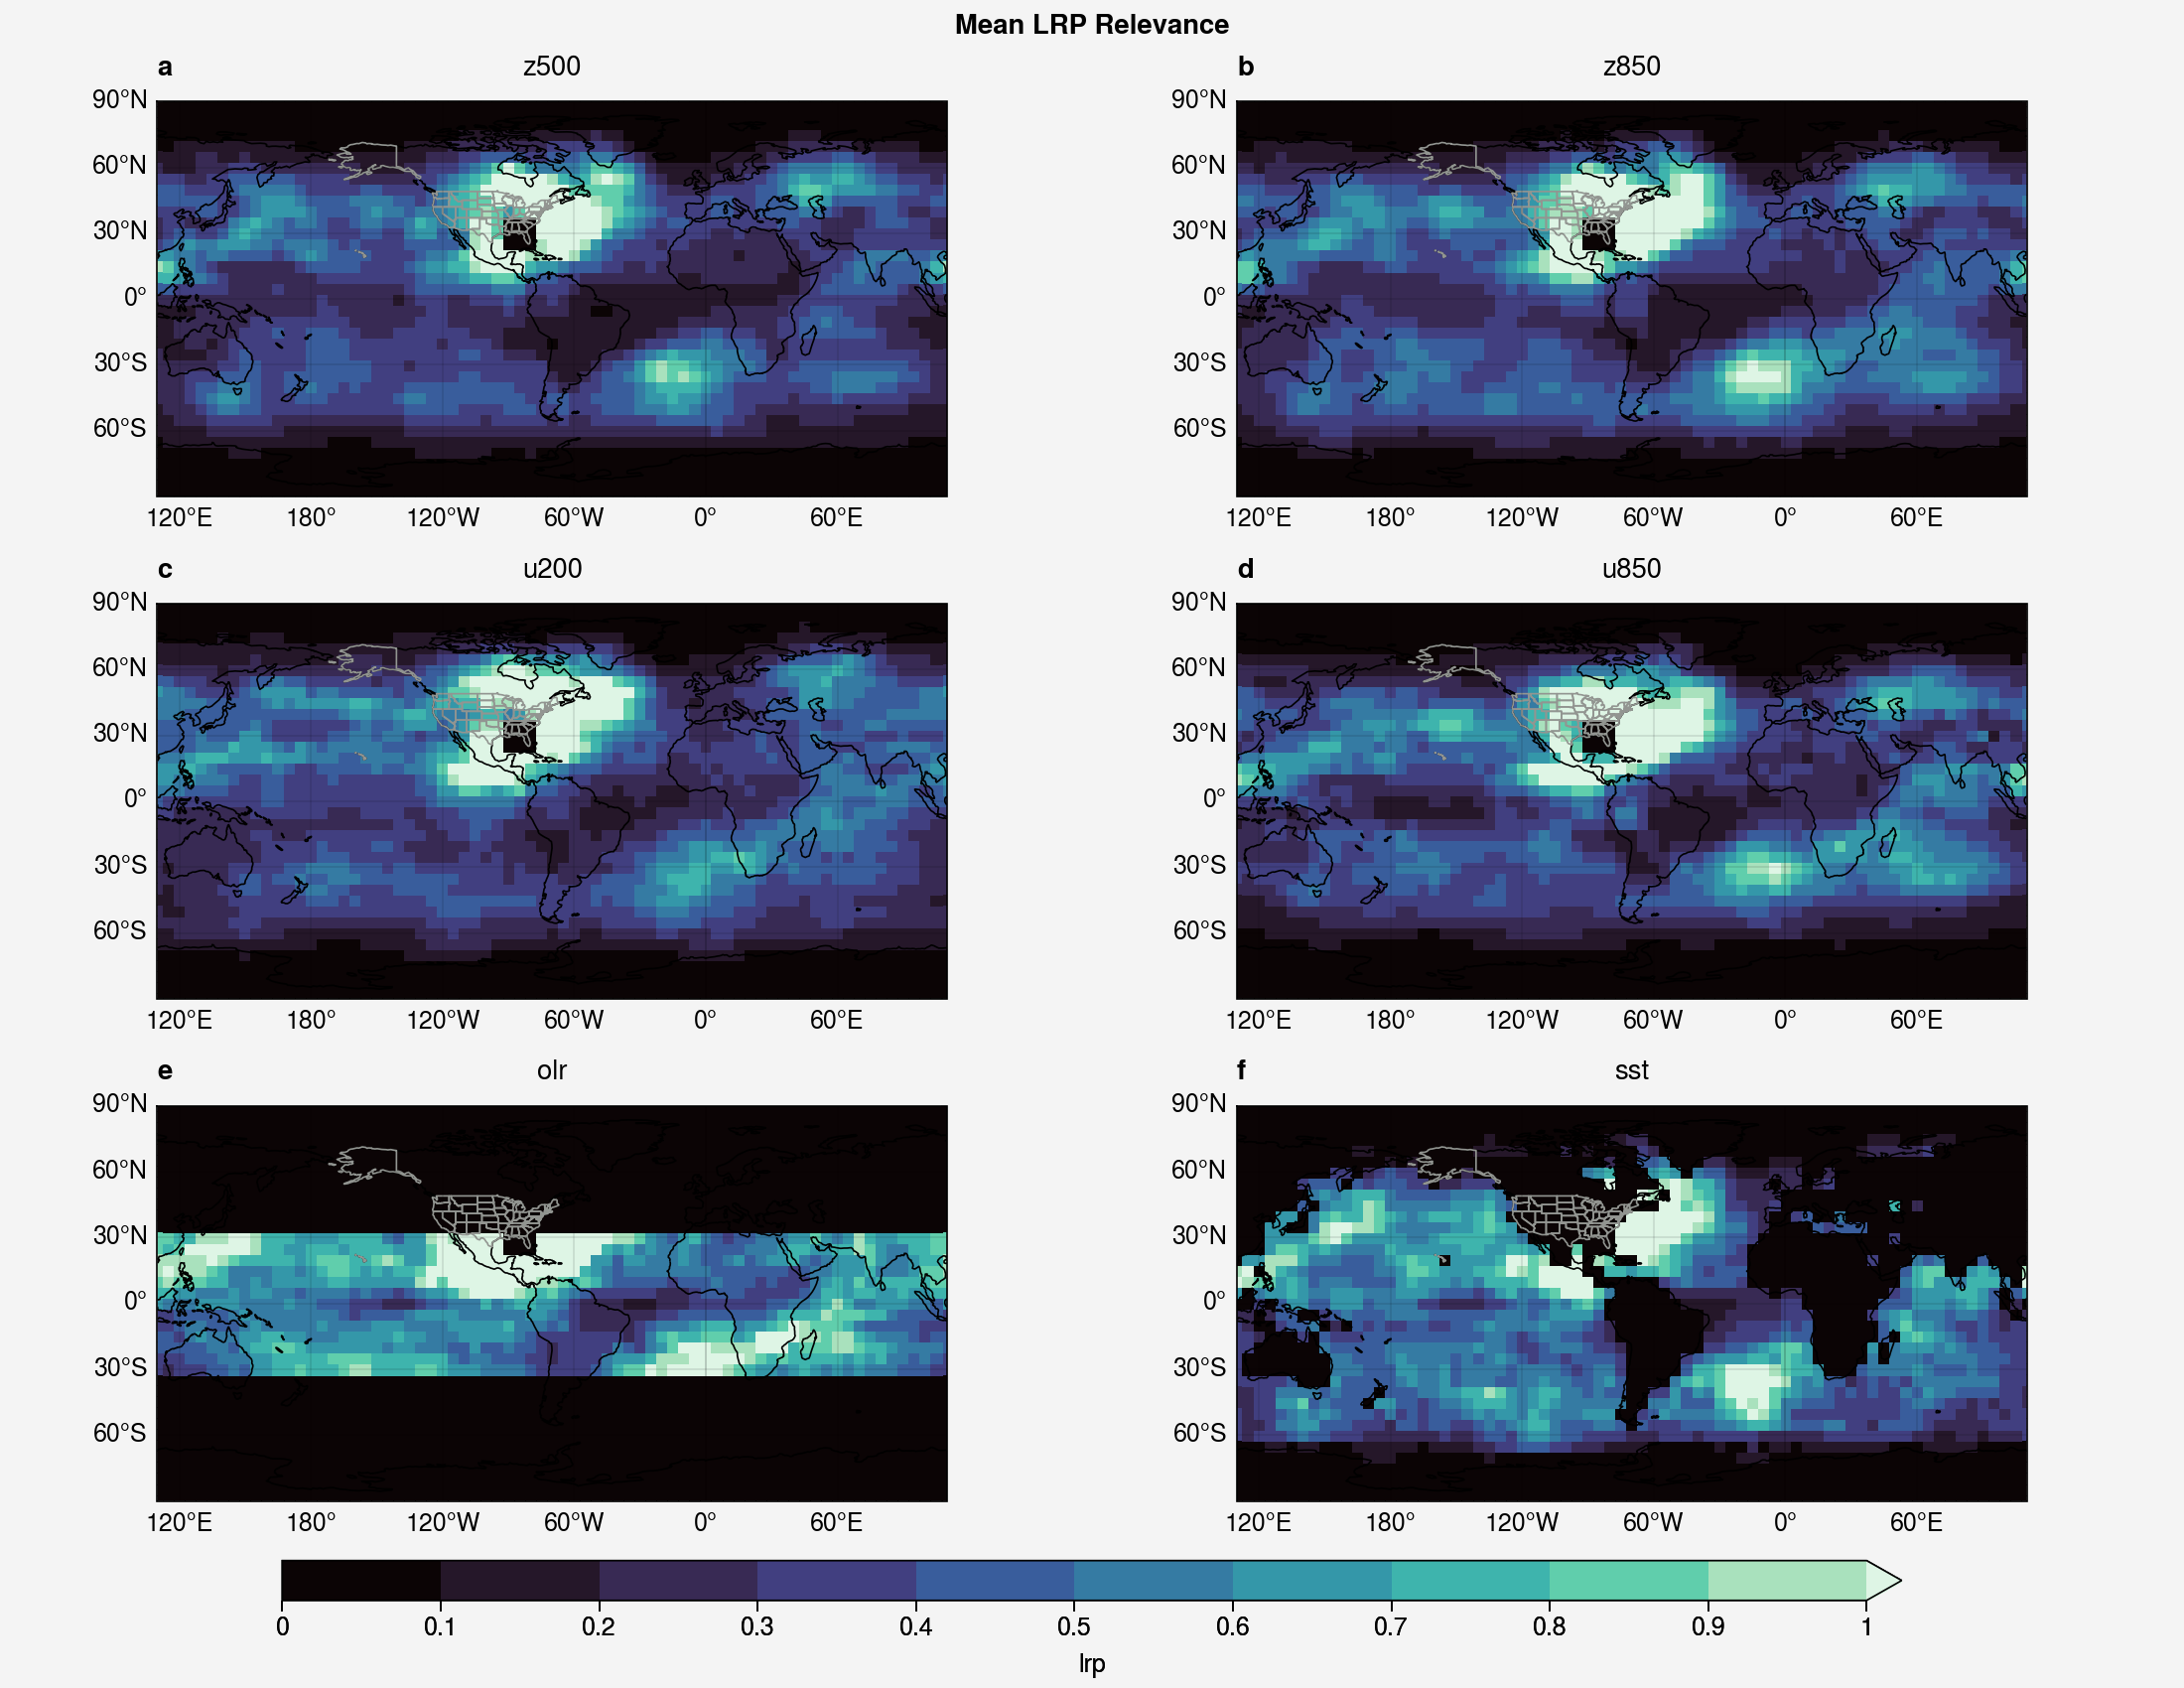

In [16]:
confidence_thresh=0.8
fcsts=ds_model.where(np.logical_and(ds_model['pred']==ds_model['verif'],
                                    ds_model['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat')
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Lower')))))
print(count_str)

plotLRP_map(fcsts,['time','model'],'lrp.alpha_1_beta_0',cm='mako')

In [17]:
ds_comp=ds_anoms.where(np.logical_and(ds_model['pred']==ds_model['verif'],
                                      ds_model['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])

In [18]:
levs_sst=np.arange(-1,1.1,0.1)
levs_z500=np.arange(-700,700,50)
levs_z850=np.arange(-400,450,50)
levs_olr=np.arange(-14,15,2)
levs_u200=np.arange(-10,12,2)
levs_u850=np.arange(-10,12,2)
clevs=[levs_sst,levs_z500,levs_z850,levs_olr,levs_u200,levs_u850]


/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


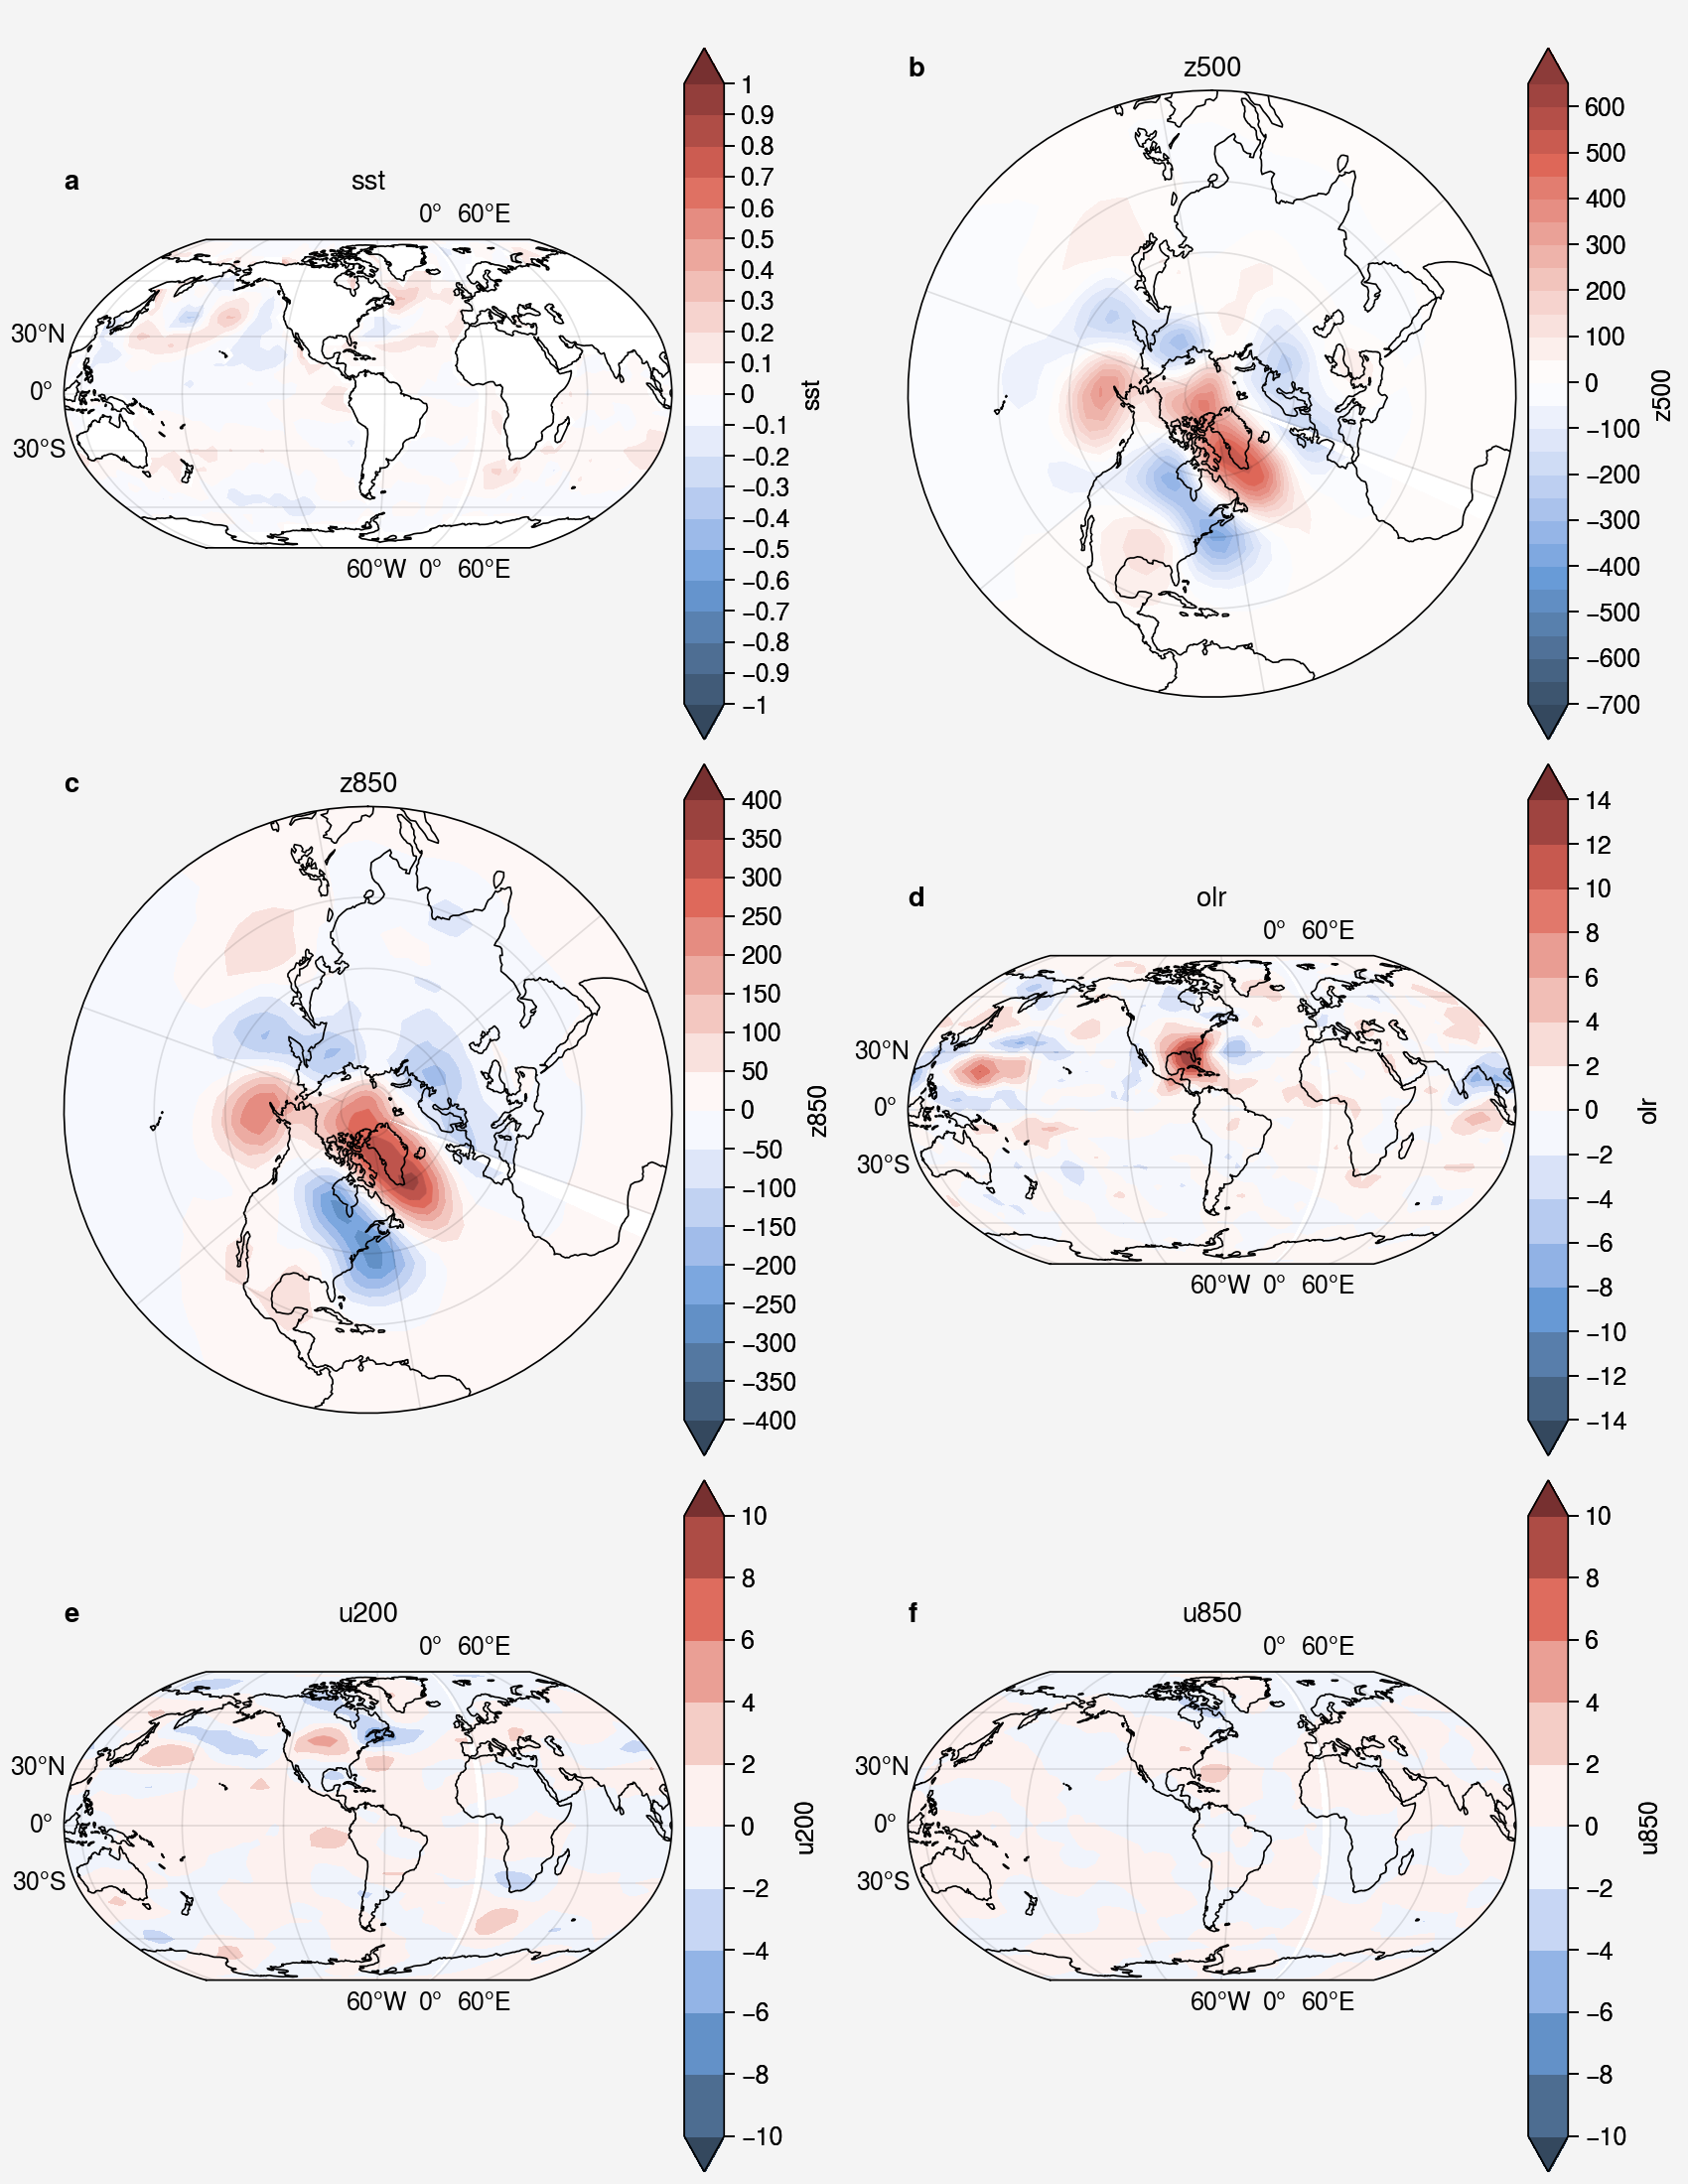

In [19]:
lon_0=290
f, axs = pplt.subplots(ncols=2, nrows=3,
                       proj=['robin','npstere','npstere','robin','robin','robin'],proj_kw={'lon_0': lon_0},
                      width=8.5,height=11)

for i,(ax,v) in enumerate(zip(axs,list(ds.keys()))):
    m=ax.contourf(ds_comp['lon'],ds_comp['lat'],ds_comp[v],levels=clevs[i],extend='both')
    ax.format(coast=True,grid=True,lonlabels='b', latlabels='l',title=v,abc=True)
    ax.colorbar(m)

### True Positive Relevance

688
z500 GeoAxesSubplot(nrows=3, ncols=2, index=(0, 0), number=1, backend='cartopy')
z850 GeoAxesSubplot(nrows=3, ncols=2, index=(1, 1), number=2, backend='cartopy')
u200 GeoAxesSubplot(nrows=3, ncols=2, index=(2, 2), number=3, backend='cartopy')
u850 GeoAxesSubplot(nrows=3, ncols=2, index=(3, 3), number=4, backend='cartopy')
olr GeoAxesSubplot(nrows=3, ncols=2, index=(4, 4), number=5, backend='cartopy')
sst GeoAxesSubplot(nrows=3, ncols=2, index=(5, 5), number=6, backend='cartopy')


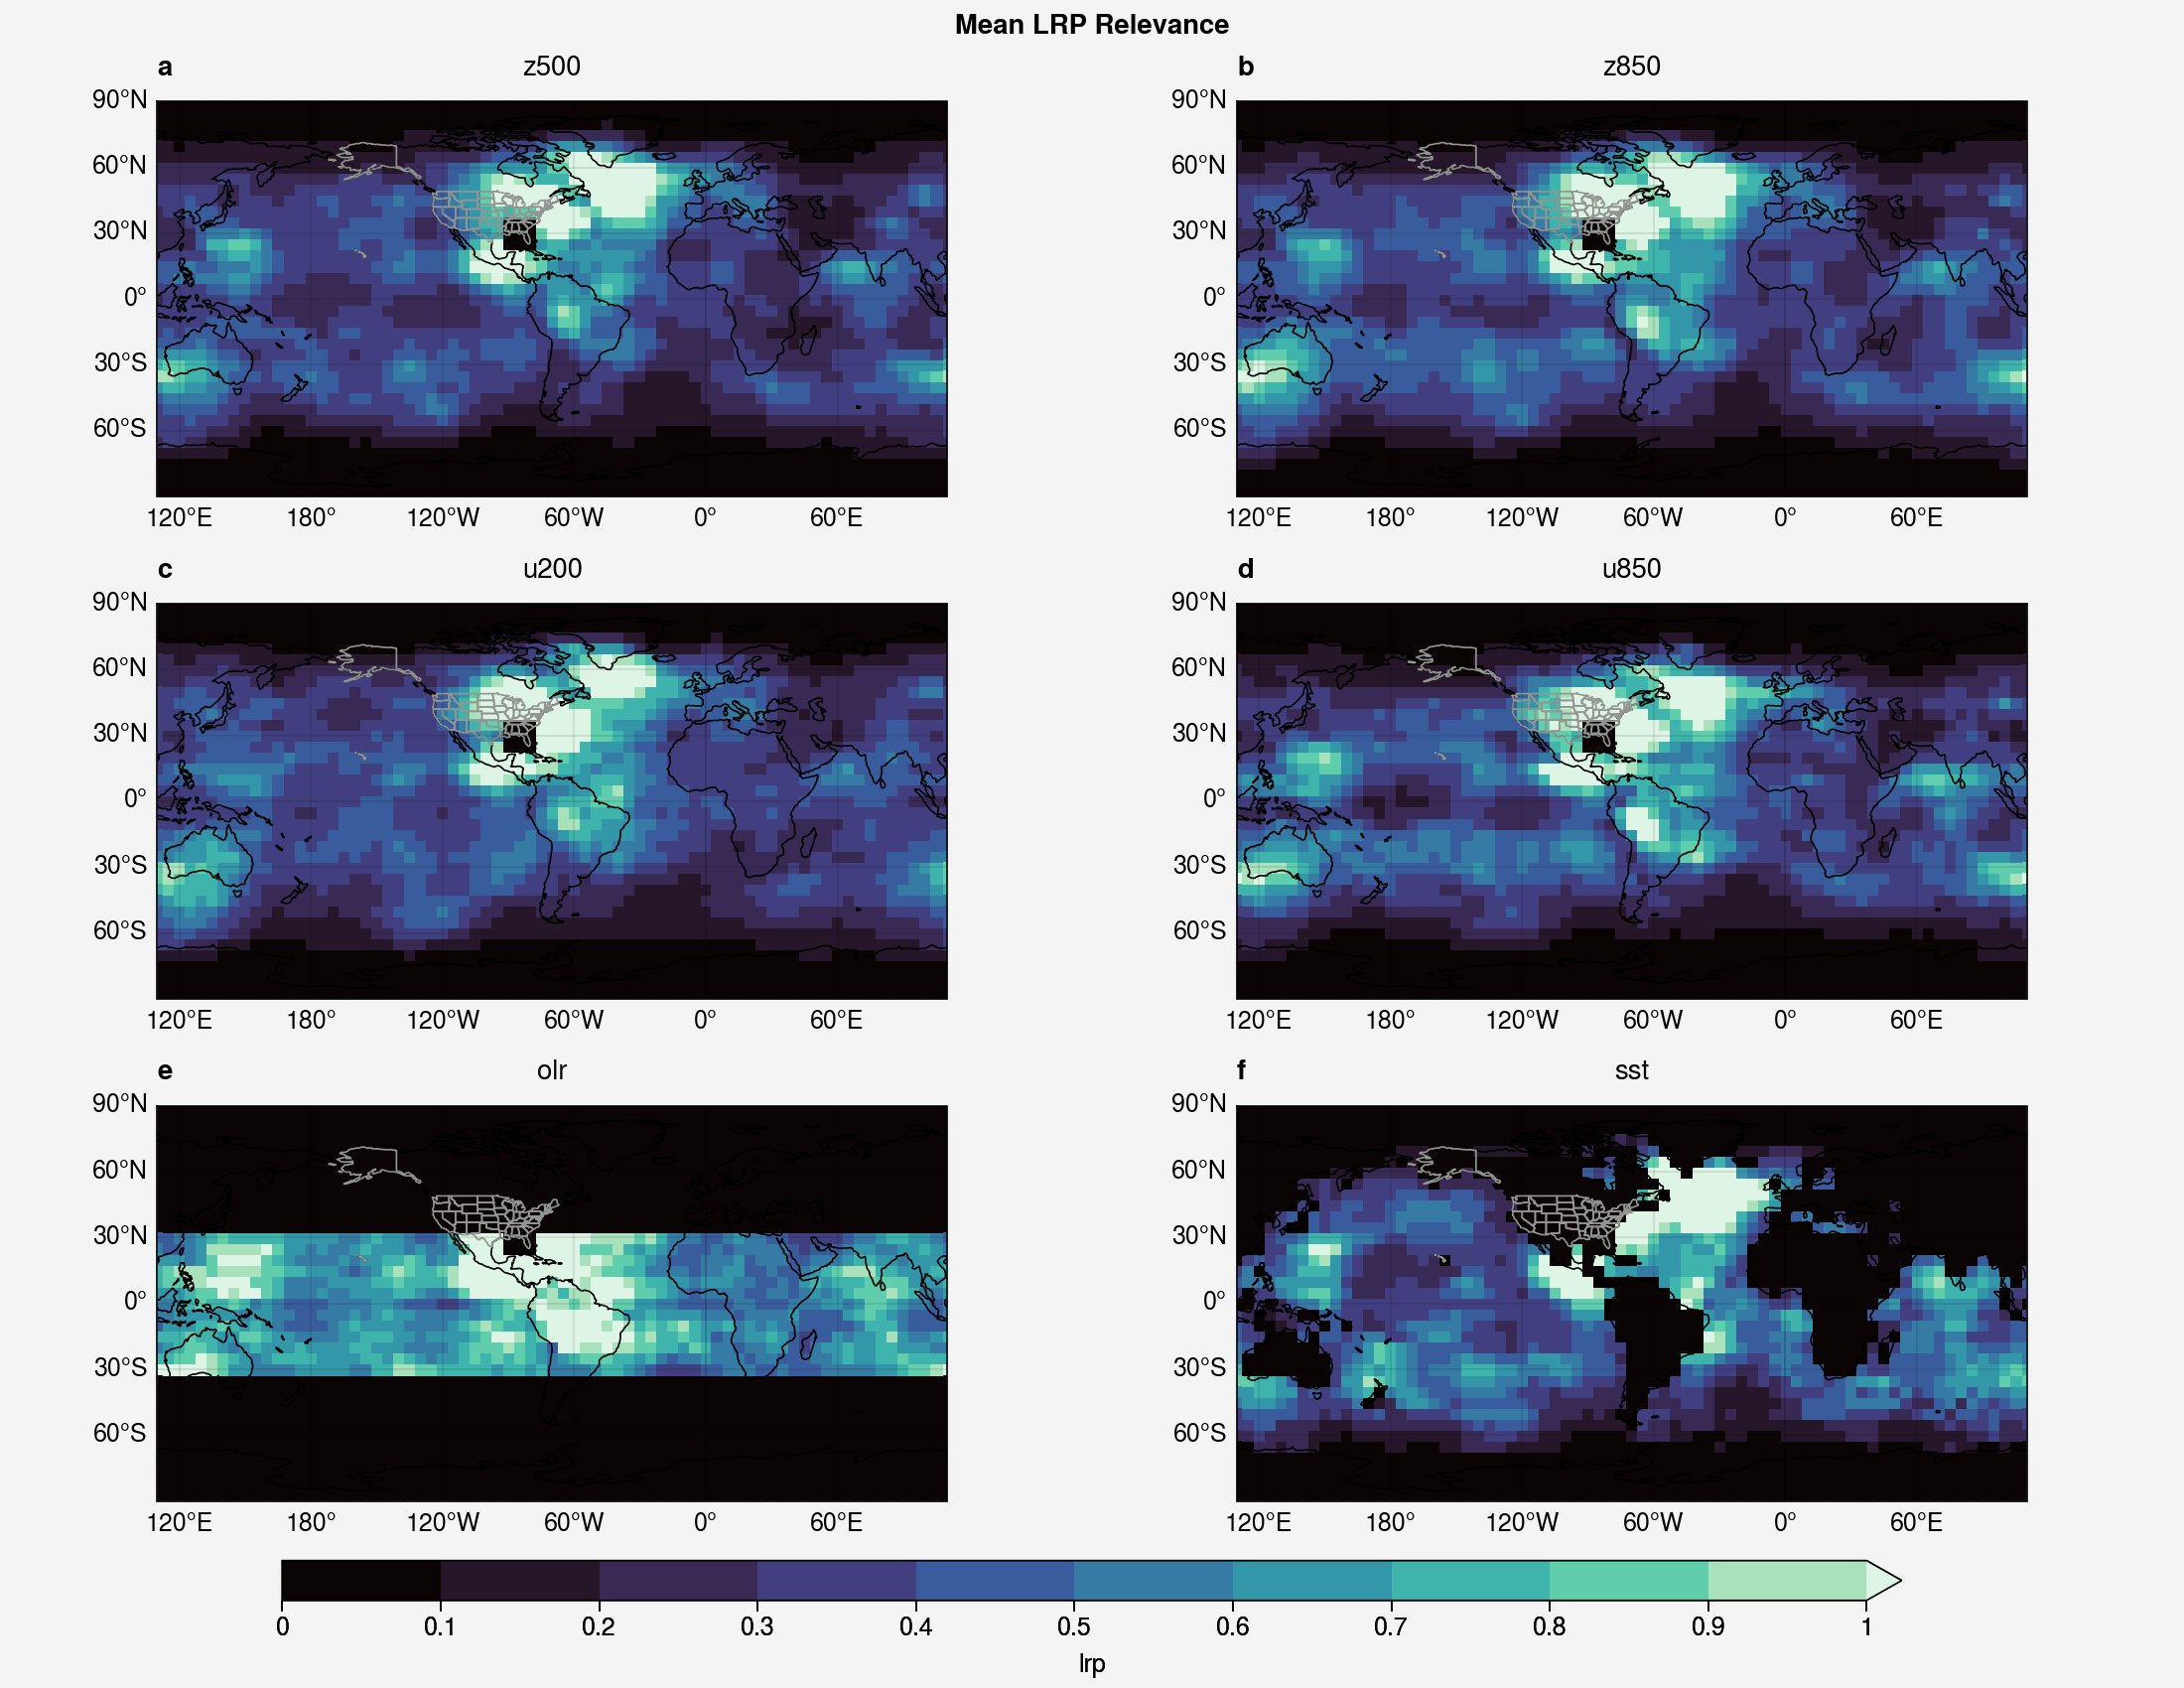

In [20]:
confidence_thresh=0.8
fcsts=ds_model.where(np.logical_and(ds_model['pred']==ds_model['verif'],
                                    ds_model['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat')
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Upper')))))
print(count_str)

plotLRP_map(fcsts,['time','model'],'lrp.alpha_1_beta_0',cm='mako')

In [21]:
ds_comp=ds_anoms.where(np.logical_and(ds_model['pred']==ds_model['verif'],
                                      ds_model['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])


In [ ]:
lon_0=290
f, axs = pplt.subplots(ncols=2, nrows=3,
                        proj=['robin','npstere','npstere','robin','robin','robin'],proj_kw={'lon_0': lon_0},
                      width=8.5,height=11)


for i,(ax,v) in enumerate(zip(axs,list(ds.keys()))):
    m=ax.contourf(ds_comp['lon'],ds_comp['lat'],ds_comp[v],levels=clevs[i],extend='both')
    ax.format(coast=True,grid=True,lonlabels='b', latlabels='l',title=v,abc=True)
    ax.colorbar(m)

### False Negative

In [ ]:
confidence_thresh=0.8
fcsts=ds_model.where(np.logical_and(ds_model['pred']!=ds_model['verif'],
                                    ds_model['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat')
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Lower')))))
print(count_str)

plotLRP_map(fcsts,['time','model'],'lrp.alpha_1_beta_0',cm='mako')

In [ ]:
ds_comp=ds_anoms.where(np.logical_and(ds_model['pred']!=ds_model['verif'],
                                      ds_model['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])


In [ ]:
lon_0=290
f, axs = pplt.subplots(ncols=2, nrows=3,
                        proj=['robin','npstere','npstere','robin','robin','robin'],proj_kw={'lon_0': lon_0},
                      width=8.5,height=11)


for i,(ax,v) in enumerate(zip(axs,list(ds.keys()))):
    m=ax.contourf(ds_comp['lon'],ds_comp['lat'],ds_comp[v],levels=clevs[i],extend='both')
    ax.format(coast=True,grid=True,lonlabels='b', latlabels='l',title=v,abc=True)
    ax.colorbar(m)

### False Positive

In [ ]:
confidence_thresh=0.8
fcsts=ds_model.where(np.logical_and(ds_model['pred']!=ds_model['verif'],
                                    ds_model['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat')
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Upper')))))
print(count_str)

plotLRP_map(fcsts,['time','model'],'lrp.alpha_1_beta_0',cm='mako')

In [ ]:
ds_comp=ds_anoms.where(np.logical_and(ds_model['pred']!=ds_model['verif'],
                                      ds_model['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])


In [ ]:
lon_0=290
f, axs = pplt.subplots(ncols=2, nrows=3,
                       proj=['robin','npstere','npstere','robin','robin','robin'],proj_kw={'lon_0': lon_0},
                      width=8.5,height=11)


for i,(ax,v) in enumerate(zip(axs,list(ds.keys()))):
    m=ax.contourf(ds_comp['lon'],ds_comp['lat'],ds_comp[v],levels=clevs[i],extend='both')
    ax.format(coast=True,grid=True,lonlabels='b', latlabels='l',title=v,abc=True)
    ax.colorbar(m)

### Test Load of Model and Model Summary

In [3]:
fname='../data/cnn/seus.median.JJA.cnn_cat.0.h5'
model=load_model(fname)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 37, 93, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 91, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 89, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 85, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 83, 64)        18496     
______________________

### To-Do
1. Model tuning
2. Logistic test/comparison
5. Model predicted features